In [1]:
from gensim.models import Word2Vec
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import enchant
from tqdm import tqdm
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from SSE import SpreadIndexCalculator, tfidf, WordFrequencyCalculator, find_most_similar_words_per_year

Load file & fine-tuned models.

In [2]:
tokens = np.load('tokens_per_year_bigrams.npy',allow_pickle='FALSE').item()

In [3]:
models = {}  
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
for year in years:
    file_name = f"word2vec_{year}_sg9.model"
    
    if os.path.exists(file_name):
        loaded_model = Word2Vec.load(file_name)
        models[year] = loaded_model
        print(f"Model for {year} successfully uploaded.")
    else:
        print(f"Model for {year} not found: {file_name}.")

Model for 2006 successfully uploaded.
Model for 2007 successfully uploaded.
Model for 2008 successfully uploaded.
Model for 2009 successfully uploaded.
Model for 2010 successfully uploaded.
Model for 2011 successfully uploaded.
Model for 2012 successfully uploaded.
Model for 2013 successfully uploaded.
Model for 2014 successfully uploaded.
Model for 2015 successfully uploaded.
Model for 2016 successfully uploaded.
Model for 2017 successfully uploaded.
Model for 2018 successfully uploaded.
Model for 2019 successfully uploaded.
Model for 2020 successfully uploaded.
Model for 2021 successfully uploaded.
Model for 2022 successfully uploaded.
Model for 2023 successfully uploaded.


In [4]:
# SAVE THE VECTORS:
ft_vectors = {}
for year, model in models.items():
    word_vectors = model.wv  
    ft_vectors[year] = word_vectors

Compute pairwise cosine similarity between 'circular_economy' embeddings.

In [5]:
embeddings_list = []
for year, word_vectors in ft_vectors.items():
    try:
        embedding = np.array(word_vectors['circular_economy']).reshape(1, -1)
        embeddings_list.append((year, embedding))
    except KeyError:
        print(f"'circular_economy' not in {year}")

# Compute pairwise similarity between consecutive years
years = []
similarities = []
for i in range(len(embeddings_list)-1):
    year1, emb1 = embeddings_list[i]
    year2, emb2 = embeddings_list[i+1]
    
    # Compute similarity score
    similarity = cosine_similarity(emb1, emb2)[0][0]
    similarities.append(similarity)
    years.append(f"{year1}-{year2}")
    
    print(f'Similarity bewteen {year1} and {year2}: {similarity}')

Similarity bewteen 2006 and 2007: 0.6794662475585938
Similarity bewteen 2007 and 2008: 0.6103428602218628
Similarity bewteen 2008 and 2009: 0.6009160876274109
Similarity bewteen 2009 and 2010: 0.580262303352356
Similarity bewteen 2010 and 2011: 0.6329073905944824
Similarity bewteen 2011 and 2012: 0.6122532486915588
Similarity bewteen 2012 and 2013: 0.6500951051712036
Similarity bewteen 2013 and 2014: 0.5688116550445557
Similarity bewteen 2014 and 2015: 0.5593661069869995
Similarity bewteen 2015 and 2016: 0.6264145970344543
Similarity bewteen 2016 and 2017: 0.6680665016174316
Similarity bewteen 2017 and 2018: 0.7267072796821594
Similarity bewteen 2018 and 2019: 0.7061827182769775
Similarity bewteen 2019 and 2020: 0.7284483909606934
Similarity bewteen 2020 and 2021: 0.759133517742157
Similarity bewteen 2021 and 2022: 0.7359896898269653
Similarity bewteen 2022 and 2023: 0.7860723733901978


Compute the similarity matrix between 'circular_economy' vector representations in time.

In [6]:
n = len(embeddings_list)
years = [pair[0] for pair in embeddings_list] 
similarity_df = pd.DataFrame(index=years, columns=years)

for i in range(n):
    for j in range(n):
        year1, emb1 = embeddings_list[i]
        year2, emb2 = embeddings_list[j]
        if i == j: 
            similarity_df.at[year1, year2] = 1
        else:
            similarity = cosine_similarity(emb1, emb2)[0][0]
            similarity_df.at[year1, year2] = similarity
            
similarity_df = similarity_df.astype(float)

In [ ]:
similarity_df

In [7]:
max_value = similarity_df[similarity_df < 1].max().max()
print(f"Max similarity value: {max_value}")

min_value = similarity_df[similarity_df > 0].min().min()
print(f"Min similarity value: {min_value}")

max_pairs = [(i, j) for i in similarity_df.columns for j in similarity_df.index if similarity_df.at[j, i] == max_value]
print(f"Pairs of maximum similarity: {max_pairs}")

min_pairs = [(i, j) for i in similarity_df.columns for j in similarity_df.index if similarity_df.at[j, i] == min_value]
print(f"Pairs of minimum similarity: {min_pairs}")

Max similarity value: 0.7860723733901978
Min similarity value: 0.29787957668304443
Pairs of maximum similarity: [('2022', '2023'), ('2023', '2022')]
Pairs of minimum similarity: [('2009', '2023'), ('2023', '2009')]


Compute the mean spread by year and across years.

In [8]:
sic = SpreadIndexCalculator(models)

In [9]:
ce_index_in_time = sic.spread_index_per_year('circular_economy') 

In [10]:
ce_index_in_time

{'2006': 0.2228637,
 '2007': 0.22575557,
 '2008': 0.2828852,
 '2009': 0.659581,
 '2010': 0.43859118,
 '2011': 0.60465944,
 '2012': 0.35647455,
 '2013': 0.45329222,
 '2014': 0.29937857,
 '2015': 0.3321853,
 '2016': 0.26163888,
 '2017': 0.34349537,
 '2018': 0.12333861,
 '2019': 0.24252686,
 '2020': 0.25583664,
 '2021': 0.14126694,
 '2022': 0.23036768,
 '2023': 0.20677996}

In [11]:
spread_index_ce = sic.spread_index_in_time('circular_economy')

In [12]:
spread_index_ce

0.21399437

Extract the most relevant words per year using **tfidf**.

In [13]:
tfidf_per_year = tfidf(tokens)

In [14]:
top_tokens_per_year = {}

for year, data in tfidf_per_year.items():
    print(f"Anno: {year}")
    top_tokens = sorted(data.items(), key=lambda item: item[1], reverse=True)[:20]
    top_tokens_per_year[year] = top_tokens
    for token, tf_idf in top_tokens:
        print(f"\tToken: {token}, TF-IDF: {tf_idf}")

Anno: 2006
	Token: deer, TF-IDF: 0.0030889782867359163
	Token: aggregative, TF-IDF: 0.002076870581136924
	Token: forage, TF-IDF: 0.0013544808137849495
	Token: environmentalism, TF-IDF: 0.0011802450671259358
	Token: hyper, TF-IDF: 0.001132625371803169
	Token: antipollution, TF-IDF: 0.0010983033908394358
	Token: breeding, TF-IDF: 0.0008237275431295773
	Token: avail, TF-IDF: 0.0006864396192746474
	Token: husbandry, TF-IDF: 0.0006491347869192644
	Token: itemized, TF-IDF: 0.0006320910464329766
	Token: wildlife, TF-IDF: 0.0005826922107212211
	Token: dispatching, TF-IDF: 0.00054179232551398
	Token: spotted, TF-IDF: 0.00054179232551398
	Token: ensilage, TF-IDF: 0.00054179232551398
	Token: pinch, TF-IDF: 0.0005037906595973785
	Token: deceleration, TF-IDF: 0.00048050773349225324
	Token: excrement, TF-IDF: 0.0004478139196421143
	Token: ferment, TF-IDF: 0.0004478139196421143
	Token: defense, TF-IDF: 0.0004461857525285208
	Token: lane, TF-IDF: 0.00044019720391398365
Anno: 2007
	Token: cwm, TF-IDF: 

# NSC concepts:
I have defined 3 vocabularies:
The first *nsc_vocab* contains both the 9 R's and concepts related to them.\
In *nsc_vocab_wo_9r* I have removed words from 9 R's to create a word cloud of specific concepts, rather than more vague, and common ones. \
In *nsc_vocab_9rs* I only included words of the 9R's framework.

In [15]:
nsc_vocab = {'Narrow': ['refuse', 'consumer_awareness','sustainable_consumption', 'sustainable_production', 'waste_prevention', 'waste_reduction',
                        'rethink', 'waste_minimization', 'energy_efficiency', 'lean_production', 
                        'reduce','ecological_efficiency', 'resource_optimization', 'green_energy', 'resource_efficiency'],

             'Slow': ['reuse', 'product_life', 'sharing_economy', 'secondhand', 'product_service','redistribution',
                      'repair', 'restore', 'product_longevity', 'mending',  'reverse_logistic', 'restoration', 'reusing',
                      'refurbish','recondition', 'restore', 'renovate', 'repairing', 'refurbishing'],

             'Close': ['remanufacture','closed_loop', 'waste_valorization', 'resource_conservation', 'resource_recovery', 'material_recovery', 
                        'recycling','industrial_ecosystem', 'industrial_symbiosis', 'industrial_ecology', 'waste_management', 'waste_stream',
                    'reprocess', 'recuperate','material_recovery', 'bio_mimicry', 'urban_metabolism']}

In [16]:
nsc_vocab_wo_9r = {'Narrow': [ 'consumer_awareness','sustainable_consumption', 'sustainable_production', 'waste_prevention', 'waste_reduction',
                         'waste_minimization', 'energy_efficiency', 'lean_production', 
                        'ecological_efficiency', 'resource_optimization', 'green_energy', 'resource_efficiency'],

             'Slow': [ 'product_life', 'sharing_economy', 'secondhand', 'product_service','redistribution',
                       'restore', 'product_longevity', 'mending', 'upkeep', 'reverse_logistic', 'restoration', 
                      'recondition', 'renovate', 'repairing', 'refurbishing'],

             'Close': ['closed_loop', 'waste_valorization', 'resource_conservation', 'resource_recovery', 'material_recovery', 
                        'industrial_ecosystem', 'industrial_symbiosis', 'industrial_ecology', 'waste_management', 'waste_stream',
                    'reprocess', 'recuperate', 'composting', 'material_recovery', 'bio_mimicry', 'urban_metabolism']}

In [17]:
nsc_vocab_9rs = {'Narrow': ['refuse', 'rethink','reduce'],

             'Slow': ['reuse','repair', 'refurbish'],

             'Close': ['remanufacture','recycling','reprocess']}

Compute the frequency per category, to visualize the distribution of words in time, aggregated by NSC category.

In [18]:
wfc = WordFrequencyCalculator(tokens)
nsc_frequency = wfc.calculate_word_frequencies_cat(nsc_vocab)

In [19]:
rows = []
for year, values in nsc_frequency.items():
    total_count = sum(values.values())
    for category, count in values.items():
        relative_count = count*100 / total_count
        rows.append({'Year': year, 'Category': category, 'Relative Count': relative_count})

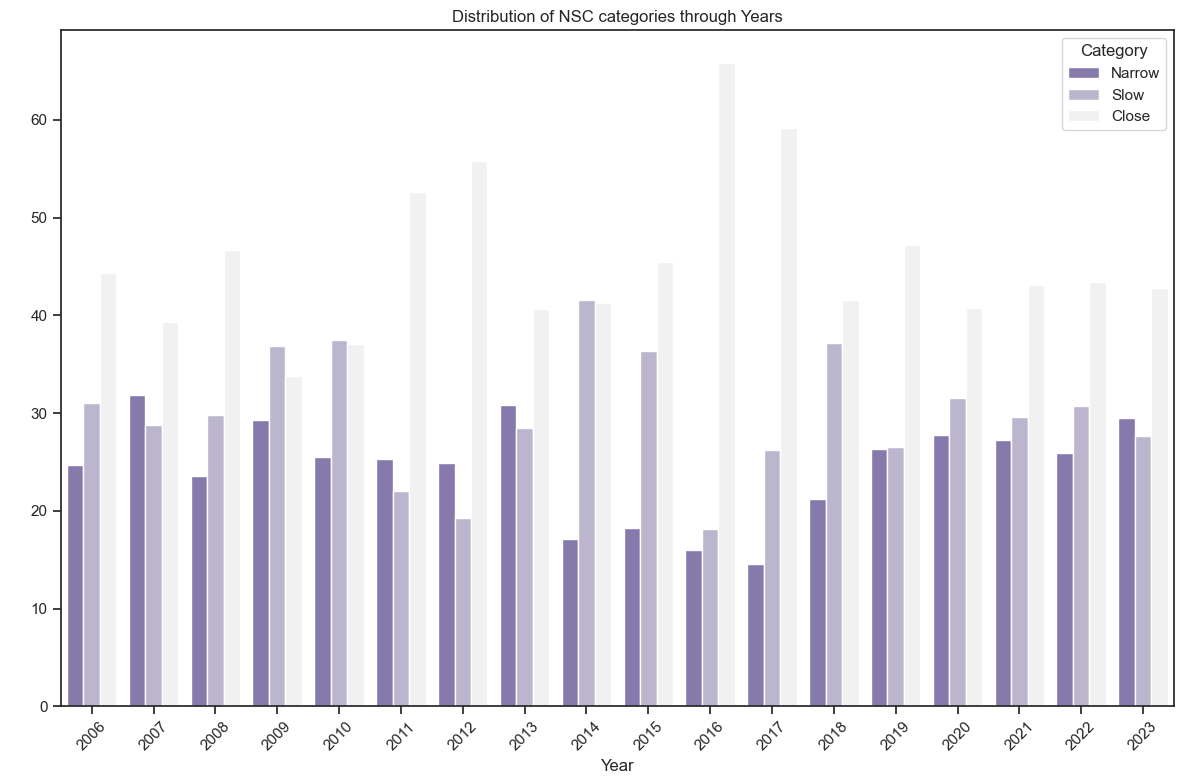

In [20]:
df_relative_cat = pd.DataFrame(rows)

sns.set_theme(style="ticks")  

plt.figure(figsize=(12, 8))  
sns.barplot(data=df_relative_cat, x='Year', y='Relative Count', hue='Category', palette='light:m_r')

plt.title('Distribution of NSC categories through Years')  
plt.xticks(rotation=45) 
plt.ylabel(' ')
plt.xlabel('Year')  

plt.tight_layout() 
plt.show() 

In [21]:
frequencies = wfc.calculate_detailed_word_frequencies(nsc_vocab_9rs)

rows = []

for year, categories in frequencies.items():
    for category, words in categories.items():
        total_count = sum(words.values()) 
        if total_count > 0:
            for word, count in words.items():
                relative_count = (count * 100) / total_count  # Calcola la percentuale relativa
                rows.append({'Year': year, 'Category': category, 'Word': word, 'Relative Count': relative_count})

df_relative_cat = pd.DataFrame(rows)

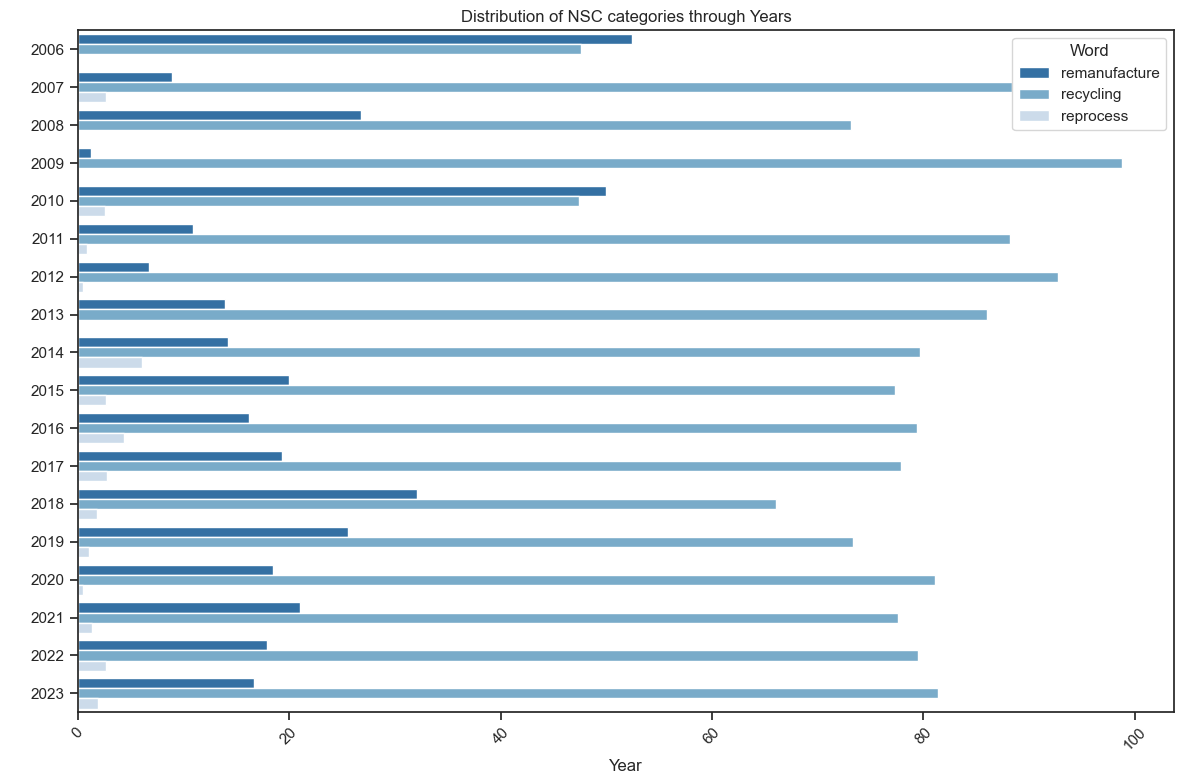

In [22]:
df_close = df_relative_cat[df_relative_cat['Category'] == 'Close']

sns.set_theme(style="ticks")  

plt.figure(figsize=(12, 8))  
sns.barplot(data=df_close, x='Relative Count', y='Year', hue='Word', palette='Blues_r')

plt.title('Distribution of NSC categories through Years')  
plt.xticks(rotation=45) 
plt.ylabel(' ')
plt.xlabel('Year')  

plt.tight_layout() 
plt.show() 

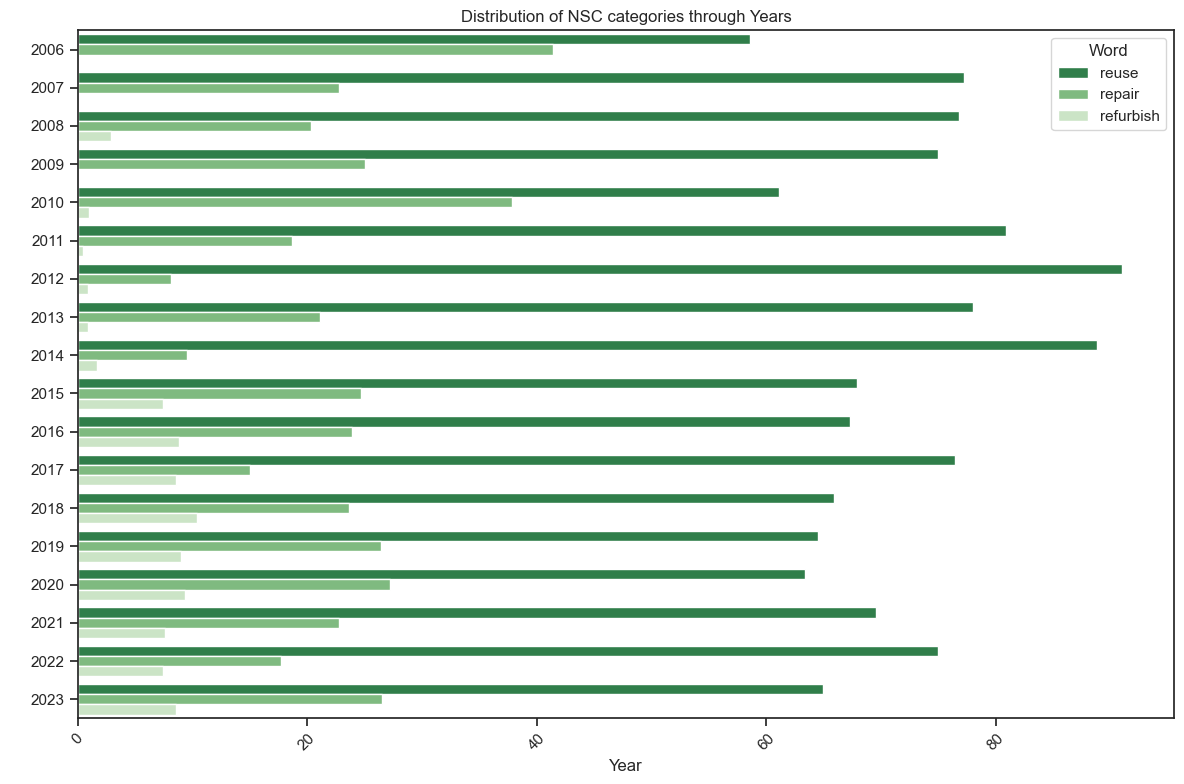

In [23]:
df_slow = df_relative_cat[df_relative_cat['Category'] == 'Slow']
sns.set_theme(style="ticks")  

plt.figure(figsize=(12, 8))  
sns.barplot(data=df_slow, x='Relative Count', y='Year', hue='Word', palette='Greens_r')

plt.title('Distribution of NSC categories through Years')  
plt.xticks(rotation=45) 
plt.ylabel(' ')
plt.xlabel('Year')  

plt.tight_layout() 
plt.show() 

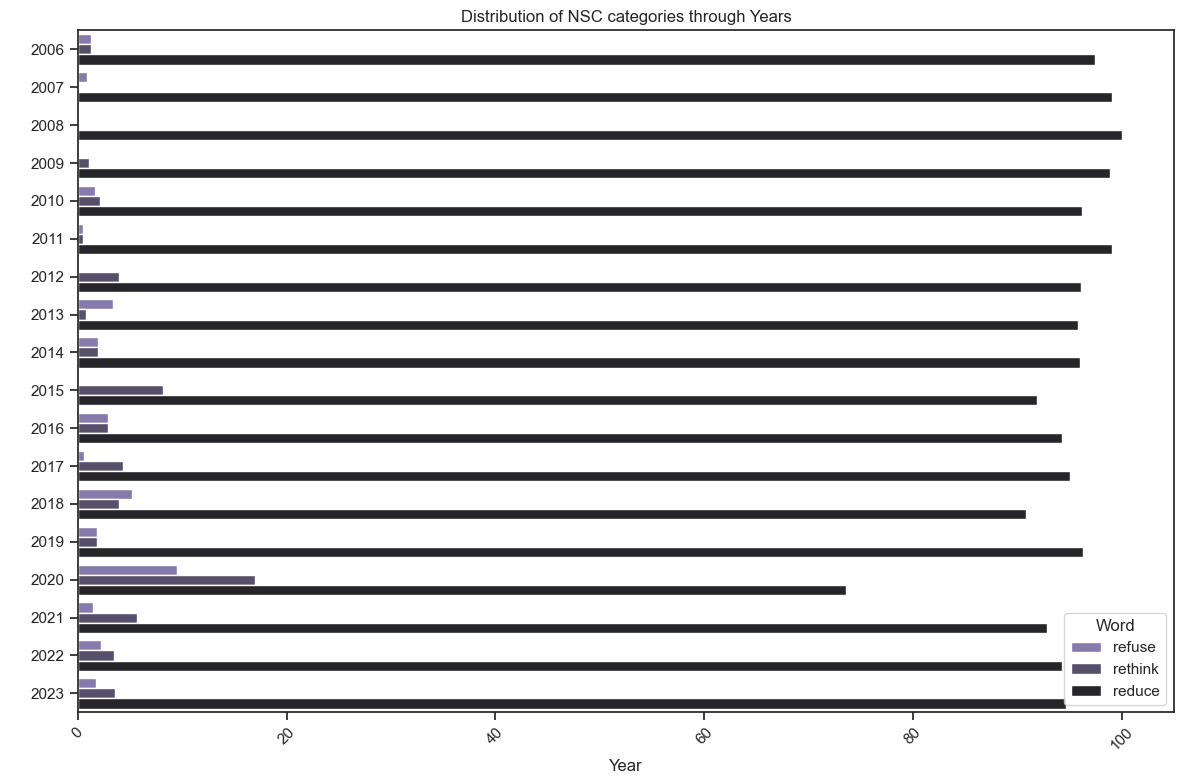

In [24]:
df_narrow = df_relative_cat[df_relative_cat['Category'] == 'Narrow']
sns.set_theme(style="ticks")  

plt.figure(figsize=(12, 8))  
sns.barplot(data=df_narrow, x='Relative Count', y='Year', hue='Word', palette='dark:m_r')

plt.title('Distribution of NSC categories through Years')  
plt.xticks(rotation=45) 
plt.ylabel(' ')
plt.xlabel('Year')  

plt.tight_layout() 
plt.show() 

In [25]:
nsc = [word for lista in nsc_vocab.values() for word in lista]

In [26]:
nsc_wo_9rs = [word for lista in nsc_vocab_wo_9r.values() for word in lista]

In [27]:
nsc_9r = [word for lista in nsc_vocab_9rs.values() for word in lista]

In [28]:
ce_exclude = ['circular', 'economy', 'economic']
ce = find_most_similar_words_per_year('circular_economy', tfidf_per_year, ft_vectors, nsc_wo_9rs, ce_exclude)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.88it/s]


In [29]:
ce

{'2006': [('industrial_ecology', 0.4322163),
  ('resource_efficiency', 0.38273665),
  ('sustainable_consumption', 0.36368415),
  ('reverse_logistic', 0.3545813),
  ('closed_loop', 0.34519076),
  ('industrial_symbiosis', 0.33943388),
  ('product_life', 0.31293207),
  ('renovate', 0.2678583),
  ('ecological_efficiency', 0.25356627),
  ('waste_management', 0.2532142)],
 '2007': [('closed_loop', 0.5327532),
  ('resource_efficiency', 0.4437881),
  ('waste_management', 0.43428716),
  ('reverse_logistic', 0.40702552),
  ('waste_reduction', 0.35922706),
  ('product_life', 0.3462342),
  ('material_recovery', 0.32569396),
  ('industrial_symbiosis', 0.31357324),
  ('resource_recovery', 0.3109383),
  ('industrial_ecology', 0.2961318)],
 '2008': [('industrial_ecology', 0.44761127),
  ('closed_loop', 0.37800536),
  ('ecological_efficiency', 0.34376276),
  ('waste_management', 0.31303456),
  ('industrial_symbiosis', 0.31186068),
  ('resource_recovery', 0.28722984),
  ('product_service', 0.26467952),


For significant words in the NSC literature.

In [30]:
reuse = find_most_similar_words_per_year('reuse', tfidf_per_year, ft_vectors, None, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:45<00:00,  2.51s/it]


In [31]:
reuse

{'2006': [('recycle', 0.62945485),
  ('recovery', 0.6063924),
  ('products', 0.57159454),
  ('recover', 0.5686097),
  ('byproduct', 0.5490619),
  ('waste', 0.54451454),
  ('secondary', 0.5396874),
  ('principle', 0.53915256),
  ('manufacturing', 0.536003),
  ('use', 0.52969104)],
 '2007': [('principle', 0.54771805),
  ('material', 0.5327914),
  ('aim', 0.5276404),
  ('worn', 0.51995724),
  ('recovery', 0.5142398),
  ('mean', 0.5083233),
  ('efficient', 0.50729513),
  ('waste', 0.49416178),
  ('resource', 0.49386984),
  ('product_life', 0.4827296)],
 '2008': [('recycle', 0.5612719),
  ('product', 0.52721477),
  ('use', 0.5259861),
  ('maintenance', 0.52520573),
  ('parts', 0.508222),
  ('aim', 0.50749725),
  ('centers', 0.49852428),
  ('resource_recovery', 0.4968118),
  ('method', 0.4941973),
  ('function', 0.4854923)],
 '2009': [('waste', 0.6824847),
  ('category', 0.61291474),
  ('ratio', 0.6089299),
  ('rubbish', 0.5878035),
  ('disposal', 0.5438385),
  ('classify', 0.5381898),
  ('d

In [32]:
reuse = find_most_similar_words_per_year('reuse', tfidf_per_year, ft_vectors, nsc_wo_9rs, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 57.95it/s]


In [33]:
reuse

{'2006': [('waste_reduction', 0.4328169),
  ('product_life', 0.42660838),
  ('repairing', 0.42042372),
  ('resource_efficiency', 0.39659154),
  ('closed_loop', 0.39525318),
  ('material_recovery', 0.39175868),
  ('renovate', 0.38681057),
  ('product_service', 0.3604537),
  ('waste_stream', 0.36031705),
  ('industrial_ecology', 0.34467128)],
 '2007': [('product_life', 0.4827296),
  ('restore', 0.44403565),
  ('resource_efficiency', 0.44122064),
  ('restoration', 0.41614902),
  ('closed_loop', 0.40946388),
  ('waste_reduction', 0.3887493),
  ('reverse_logistic', 0.37828642),
  ('resource_recovery', 0.36444497),
  ('composting', 0.35482353),
  ('waste_management', 0.30197418)],
 '2008': [('resource_recovery', 0.4968118),
  ('restore', 0.4726243),
  ('reverse_logistic', 0.35384458),
  ('product_life', 0.3522271),
  ('waste_management', 0.32739177),
  ('recondition', 0.3234222),
  ('closed_loop', 0.3122288),
  ('waste_minimization', 0.30976558),
  ('material_recovery', 0.3095196),
  ('resou

In [34]:
recycling = find_most_similar_words_per_year('recycling', tfidf_per_year, ft_vectors, None, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:42<00:00,  2.37s/it]


In [35]:
recycling = find_most_similar_words_per_year('recycling', tfidf_per_year, ft_vectors, nsc_wo_9rs, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 58.59it/s]


In [36]:
recycling

{'2006': [('closed_loop', 0.47623932),
  ('renovate', 0.4094051),
  ('product_life', 0.4091518),
  ('recondition', 0.39225876),
  ('industrial_ecosystem', 0.3856638),
  ('restore', 0.38533714),
  ('resource_efficiency', 0.38448036),
  ('resource_recovery', 0.3819459),
  ('waste_management', 0.36820954),
  ('waste_prevention', 0.3634379)],
 '2007': [('composting', 0.3529653),
  ('resource_conservation', 0.33850116),
  ('product_life', 0.30633178),
  ('material_recovery', 0.3061545),
  ('restore', 0.2960595),
  ('waste_stream', 0.28316563),
  ('waste_prevention', 0.28283536),
  ('resource_efficiency', 0.2763484),
  ('energy_efficiency', 0.26145822),
  ('waste_reduction', 0.25351915)],
 '2008': [('waste_management', 0.41983408),
  ('resource_recovery', 0.39070776),
  ('material_recovery', 0.38820642),
  ('waste_minimization', 0.32361057),
  ('resource_conservation', 0.3184896),
  ('reverse_logistic', 0.30460575),
  ('product_life', 0.29685748),
  ('waste_stream', 0.291727),
  ('industrial

In [37]:
reduce = find_most_similar_words_per_year('reduce', tfidf_per_year, ft_vectors, nsc_wo_9rs, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 56.80it/s]


In [38]:
reduce

{'2006': [('product_life', 0.3824014),
  ('resource_efficiency', 0.37706366),
  ('green_energy', 0.36202747),
  ('waste_prevention', 0.339999),
  ('waste_reduction', 0.3399952),
  ('closed_loop', 0.3197264),
  ('restore', 0.3043219),
  ('ecological_efficiency', 0.30340803),
  ('reverse_logistic', 0.2987243),
  ('product_service', 0.2847563)],
 '2007': [('energy_efficiency', 0.3621952),
  ('green_energy', 0.36202976),
  ('restore', 0.34369427),
  ('resource_efficiency', 0.3409369),
  ('product_life', 0.32576424),
  ('closed_loop', 0.30439115),
  ('waste_management', 0.30316266),
  ('product_service', 0.2926337),
  ('restoration', 0.28503743),
  ('waste_prevention', 0.27949095)],
 '2008': [('product_service', 0.3777811),
  ('ecological_efficiency', 0.37645906),
  ('energy_efficiency', 0.3715447),
  ('product_life', 0.30052394),
  ('restore', 0.2714863),
  ('resource_recovery', 0.25821728),
  ('waste_stream', 0.24801439),
  ('industrial_ecosystem', 0.23788974),
  ('closed_loop', 0.2197774